# Naive Bayes

## Análise de Sentimentos

In [1]:
import nltk
import re
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.model_selection import cross_val_predict

**Ler arquivo de dados e conta a quantidade de linhas**

In [2]:
dataset = pd.read_csv('Tweets_Mg.csv',encoding='utf-8')

In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8199 entries, 0 to 8198
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Unnamed: 0                 8199 non-null   int64  
 1   Created At                 8199 non-null   object 
 2   Text                       8199 non-null   object 
 3   Geo Coordinates.latitude   104 non-null    float64
 4   Geo Coordinates.longitude  104 non-null    float64
 5   User Location              5489 non-null   object 
 6   Username                   8199 non-null   object 
 7   User Screen Name           8199 non-null   object 
 8   Retweet Count              8199 non-null   int64  
 9   Classificacao              8199 non-null   object 
 10  Observação                 1 non-null      object 
 11  Unnamed: 10                0 non-null      float64
 12  Unnamed: 11                0 non-null      float64
 13  Unnamed: 12                0 non-null      float

In [4]:
# Expante o tamanho de exibição de coluna de texto
pd.set_option('display.max_colwidth', None) 

In [5]:
dataset.Text.head(100)

0                                                              ���⛪ @ Catedral de Santo Antônio - Governador Valadares/MG https://t.co/JSbKamIqUJ
1                                                                                  � @ Governador Valadares, Minas Gerais https://t.co/B3ThIDJCSf
2                                                                                 �� @ Governador Valadares, Minas Gerais https://t.co/dPkgzVR2Qw
3                                                                                                                     ��� https://t.co/BnDsO34qK0
4                  ��� PSOL vai questionar aumento de vereadores e prefeito de BH na Justiça - Politica - Estado de Minas https://t.co/DMg7BGsek5
                                                                         ...                                                                     
95                             #noticiasdorenan Uso de depósitos judiciais pelo governo tem nova polêmica em MG: O Banco… ht

**Excluir Linhas duplicadas**

In [6]:
dataset.drop_duplicates(['Text'],inplace=True)

In [7]:
dataset.count()

Unnamed: 0                   5765
Created At                   5765
Text                         5765
Geo Coordinates.latitude      104
Geo Coordinates.longitude     104
User Location                3851
Username                     5765
User Screen Name             5765
Retweet Count                5765
Classificacao                5765
Observação                      1
Unnamed: 10                     0
Unnamed: 11                     0
Unnamed: 12                     0
Unnamed: 13                     0
Unnamed: 14                     0
Unnamed: 15                     0
Unnamed: 16                     0
Unnamed: 17                     0
Unnamed: 18                     0
Unnamed: 19                     0
Unnamed: 20                     0
Unnamed: 21                     0
Unnamed: 22                     0
Unnamed: 23                     0
Unnamed: 24                     0
dtype: int64

**Removendo Colunas desnecessárias**

In [9]:
dataset.columns.values

array(['Unnamed: 0', 'Created At', 'Text', 'Geo Coordinates.latitude',
       'Geo Coordinates.longitude', 'User Location', 'Username',
       'User Screen Name', 'Retweet Count', 'Classificacao', 'Observação',
       'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13',
       'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17',
       'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20', 'Unnamed: 21',
       'Unnamed: 22', 'Unnamed: 23', 'Unnamed: 24'], dtype=object)

In [8]:
for i in dataset.columns.values:
    if i.startswith('Unnamed'):
        dataset.drop(i, axis=1, inplace=True)
        print ('Colunas Deletadas:', i)

Colunas Deletadas: Unnamed: 0
Colunas Deletadas: Unnamed: 10
Colunas Deletadas: Unnamed: 11
Colunas Deletadas: Unnamed: 12
Colunas Deletadas: Unnamed: 13
Colunas Deletadas: Unnamed: 14
Colunas Deletadas: Unnamed: 15
Colunas Deletadas: Unnamed: 16
Colunas Deletadas: Unnamed: 17
Colunas Deletadas: Unnamed: 18
Colunas Deletadas: Unnamed: 19
Colunas Deletadas: Unnamed: 20
Colunas Deletadas: Unnamed: 21
Colunas Deletadas: Unnamed: 22
Colunas Deletadas: Unnamed: 23
Colunas Deletadas: Unnamed: 24


In [9]:
# Visualizando as colunas do dataset
dataset.columns

Index(['Created At', 'Text', 'Geo Coordinates.latitude',
       'Geo Coordinates.longitude', 'User Location', 'Username',
       'User Screen Name', 'Retweet Count', 'Classificacao', 'Observação'],
      dtype='object')

**Distribuição das classes neutros, positivos e negativos**

In [10]:
dataset.Classificacao.value_counts()

Positivo    2840
Neutro      1974
Negativo     951
Name: Classificacao, dtype: int64

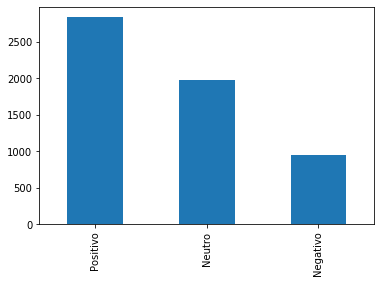

In [11]:
%matplotlib inline
dataset.Classificacao.value_counts().plot(kind='bar') # As classes se apresentaram desbalanceadas.

** Separando tweets e suas classes
**

In [12]:
tweets = dataset['Text']
classes = dataset['Classificacao']

In [20]:
tweets.head()

0    ���⛪ @ Catedral de Santo Antônio - Governador Valadares/MG https://t.co/JSbKamIqUJ                                            
1    � @ Governador Valadares, Minas Gerais https://t.co/B3ThIDJCSf                                                                
2    �� @ Governador Valadares, Minas Gerais https://t.co/dPkgzVR2Qw                                                               
3    ��� https://t.co/BnDsO34qK0                                                                                                   
4    ��� PSOL vai questionar aumento de vereadores e prefeito de BH na Justiça - Politica - Estado de Minas https://t.co/DMg7BGsek5
Name: Text, dtype: object

In [21]:
classes.head()

0    Neutro  
1    Neutro  
2    Neutro  
3    Neutro  
4    Negativo
Name: Classificacao, dtype: object

**Gerando o modelo**

Como são dados de textos, o que ira acontecer é transformar os textos em uma lista de vetores binarios.

In [13]:
vectorizer = CountVectorizer(analyzer="word")
freq_tweets = vectorizer.fit_transform(tweets)

In [14]:
type(freq_tweets)# Foi transformado em uma matriz esparça.

scipy.sparse.csr.csr_matrix

In [15]:
freq_tweets.shape # O indicadivo de colunas, mostra que cada palavra da base virou agora uma coluna.

(5765, 13029)

In [18]:
freq_tweets.A

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

**Cria um modelo usando Naive Bayes Multinomial**

In [19]:
modelo = MultinomialNB()#Este é o tipo de naive bayes que será trabalhado.
modelo.fit(freq_tweets,classes)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

** Testando o modelo com algumas instâncias simples**

In [20]:
# defina instâncias de teste dentro de uma lista
testes = ['Esse governo está no início, vamos ver o que vai dar',
          'Estou muito feliz com o governo de Minas esse ano',
          'O estado de Minas Gerais decretou calamidade financeira!!!',
          'A segurança desse país está deixando a desejar',
          'O governador de Minas é mais uma vez do PT']

In [21]:
# Transforma os dados de teste em vetores de palavras.
freq_testes = vectorizer.transform(testes)

In [22]:
modelo.predict(freq_testes)

array(['Neutro', 'Neutro', 'Negativo', 'Neutro', 'Neutro'], dtype='<U8')

In [23]:
# Fazendo a classificação com o modelo treinado.
for t, c in zip (testes,modelo.predict(freq_testes)):
    print (t +", "+ c)

Esse governo está no início, vamos ver o que vai dar, Neutro
Estou muito feliz com o governo de Minas esse ano, Neutro
O estado de Minas Gerais decretou calamidade financeira!!!, Negativo
A segurança desse país está deixando a desejar, Neutro
O governador de Minas é mais uma vez do PT, Neutro


In [24]:
# Probabilidades de cada classe

print (modelo.classes_)
modelo.predict_proba(freq_testes).round(2)

['Negativo' 'Neutro' 'Positivo']


array([[0.18, 0.82, 0.  ],
       [0.02, 0.98, 0.  ],
       [0.99, 0.01, 0.  ],
       [0.1 , 0.89, 0.01],
       [0.15, 0.85, 0.  ]])

## Avaliação o modelo ##

* Usaremos a técnica de Cross Validation para avaliação dos modelos.
* Esta técnica será usada com 10 folds.

**Fazendo o cross validation do modelo**

In [26]:
resultados = cross_val_predict(modelo, freq_tweets, classes, cv=10)
resultados

array(['Neutro', 'Neutro', 'Neutro', ..., 'Positivo', 'Positivo',
       'Positivo'], dtype='<U8')

**Matriz de confusão**

In [27]:
print (pd.crosstab(classes, resultados, rownames=['Real'], colnames=['Predito'], margins=True))

Predito   Negativo  Neutro  Positivo   All
Real                                      
Negativo       846     100         5   951
Neutro         206    1656       112  1974
Positivo        53     294      2493  2840
All           1105    2050      2610  5765


** Métricas de validação do modelo**

In [28]:
sentimento=['Positivo','Negativo','Neutro']
print (metrics.classification_report(classes,resultados,sentimento))

              precision    recall  f1-score   support

    Positivo       0.96      0.88      0.91      2840
    Negativo       0.77      0.89      0.82       951
      Neutro       0.81      0.84      0.82      1974

    accuracy                           0.87      5765
   macro avg       0.84      0.87      0.85      5765
weighted avg       0.87      0.87      0.87      5765



## Tunning do Naive Bayes

In [29]:
from sklearn.model_selection import GridSearchCV

** Defina uma lista de valores de Alpha**

In [30]:
lista_alpha = list(range(1,11))
lista_alpha

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

** Cria um dicionario com o nome do parametro e a lista de valores **
** O GridSearch faz testes exaustivo de parametros alpha no caso do Naive Bayes para a escolha dos parametros.

In [31]:
parametros_grid = dict(alpha=lista_alpha)
parametros_grid

{'alpha': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}

**Instância um modelo**

In [32]:
nvModelo = MultinomialNB()

** Cria o objeto Grid**

In [33]:
grid = GridSearchCV(nvModelo, parametros_grid, cv=10, scoring='accuracy') # Para cada valor do parametro ele roda tambem uma validação cruzada.

**Roda o Grid**

In [34]:
freq_tweets = vectorizer.fit_transform(tweets)
grid.fit(freq_tweets, classes)

GridSearchCV(cv=10, error_score=nan,
             estimator=MultinomialNB(alpha=1.0, class_prior=None,
                                     fit_prior=True),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

** Melhores Scores**

In [35]:
grid.cv_results_

{'mean_fit_time': array([0.01718595, 0.01718829, 0.01882207, 0.01772017, 0.01835465,
        0.01727026, 0.01875081, 0.01786618, 0.01779661, 0.01718588]),
 'std_fit_time': array([0.0046804 , 0.00468668, 0.00506373, 0.00135097, 0.00286565,
        0.00512534, 0.00625419, 0.00561442, 0.00256457, 0.00468702]),
 'mean_score_time': array([0.00156257, 0.        , 0.0003979 , 0.00168517, 0.00109959,
        0.00206256, 0.        , 0.00010002, 0.00206273, 0.00156248]),
 'std_score_time': array([0.00468771, 0.        , 0.00065832, 0.00163662, 0.00069976,
        0.00454571, 0.        , 0.00030005, 0.00454629, 0.00468743]),
 'param_alpha': masked_array(data=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'params': [{'alpha': 1},
  {'alpha': 2},
  {'alpha': 3},
  {'alpha': 4},
  {'alpha': 5},
  {'alpha': 6},
  {'alpha': 7},
  {'alpha': 8},
  {'alpha'

** Melhores parâmetros**

In [36]:
grid.best_params_

{'alpha': 1}

In [37]:
grid.best_score_

0.8664846307529368

In [38]:
vectorizer = CountVectorizer(analyzer="word")
freq_tweets = vectorizer.fit_transform(tweets)
modelo = MultinomialNB(alpha=5)
modelo.fit(freq_tweets,classes)

MultinomialNB(alpha=5, class_prior=None, fit_prior=True)

In [39]:
freq_testes = vectorizer.transform(testes)

In [40]:
# Fazendo a classificação com o modelo treinado.
modelo.predict(freq_testes)

array(['Neutro', 'Neutro', 'Negativo', 'Neutro', 'Neutro'], dtype='<U8')

In [41]:
resultados = cross_val_predict(modelo, freq_tweets, classes, cv=10)

In [42]:
sentimento=['Positivo','Negativo','Neutro']
print (metrics.classification_report(classes,resultados,sentimento))

              precision    recall  f1-score   support

    Positivo       0.89      0.92      0.90      2840
    Negativo       0.84      0.78      0.81       951
      Neutro       0.79      0.79      0.79      1974

    accuracy                           0.85      5765
   macro avg       0.84      0.83      0.83      5765
weighted avg       0.85      0.85      0.85      5765



A classifição das palavras negativas obteve uma melhor acuracia, por que com um maior alpha, o algoritmo deu maior peso a classe que estava desbalanceada. E em contrapartida ocorreu uma diminuição da precisão das outras classes.

** Considerações Finais**

* Considere aumentar a quantidade de dados de treino.

* Pela sua simplicidade o Naive Bayes pode ser usado perfeitamente como um algoritmo de Baseline.

* Considere alterar os parâmetros do algoritmo.

* Em tarefas de classificação de textos considere utilizar outras modelagens como Bigrams por exemplo.

* Em tarefas envolvendo textos outras técnicas como stemming ou remoção de stoptowords podem dar bons resultados.
